# Preprocessing and clustering 3k PBMCs

从 2017 年 5 月开始，Scanpy 允许复制 Seurat 的大部分[引导聚类教程](http://satijalab.org/seurat/pbmc3k_tutorial.html)（[Satija et al., 2015](https://doi.org/10.1038/nbt.3192)）。

我们非常感谢 Seurat 的作者提供的教程！与此同时，我们增加和删除了一些部分。

该数据由来自健康捐赠者的 3k PBMCs 组成，可从 10x Genomics 免费获得（[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)）。在 unix 系统上，您可以取消注释并运行以下操作来下载和解包数据。最后一行创建了一个目录，用于写入已处理的数据。

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

点击 GitHub 上的编辑按钮下载这个 notebook。在 GitHub 上，您可以通过右键单击并将链接另存为，使用 Raw 按钮进行下载。或者，下载整个 [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository。

在 Jupyter notebooks and lab 中，您可以通过点击 `SHIFT+TAB` 来查看 python 函数的文档。点击两次以展开视图。

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-10-04 10:27:55.250433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-04 10:27:55.561669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-04 10:27:55.561710: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-04 10:27:56.505986: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.8.1 pandas==1.3.5 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

将计数矩阵读入 [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) 对象，该对象包含许多用于注释和不同数据表示的 slots。它还自带基于 HDF5 的文件格式：`.h5ad`。

In [4]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


有关 `AnData` 的更全面介绍，请参阅 [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html)。

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing
## 预处理

展示所有细胞中在每个细胞中高表达的基因。

normalizing counts per cell
    finished (0:00:00)


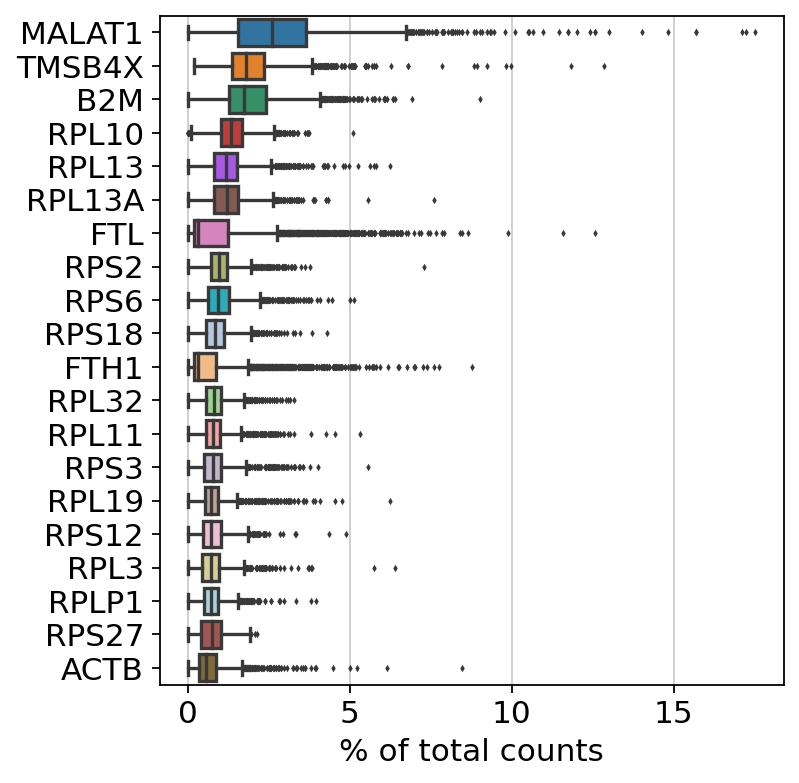

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

基本过滤：

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


让我们收集一些关于线粒体基因的信息，这些信息对质量控制很重要。

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

> 高比例表明细胞质量差（Islam et al. 2014; Ilicic et al. 2016），可能是因为穿孔细胞的细胞质 RNA 丢失。其理由是线粒体比单个转录物分子大，不太可能通过细胞膜中的撕裂逃逸。

使用 `pp.cacalculate_qc_metrics`，我们可以非常高效地计算许多度量。

In [14]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

一些计算质量指标的小提琴图：
- 计数矩阵中表达的基因数量
- 每个细胞的总计数
- 线粒体基因计数的百分比

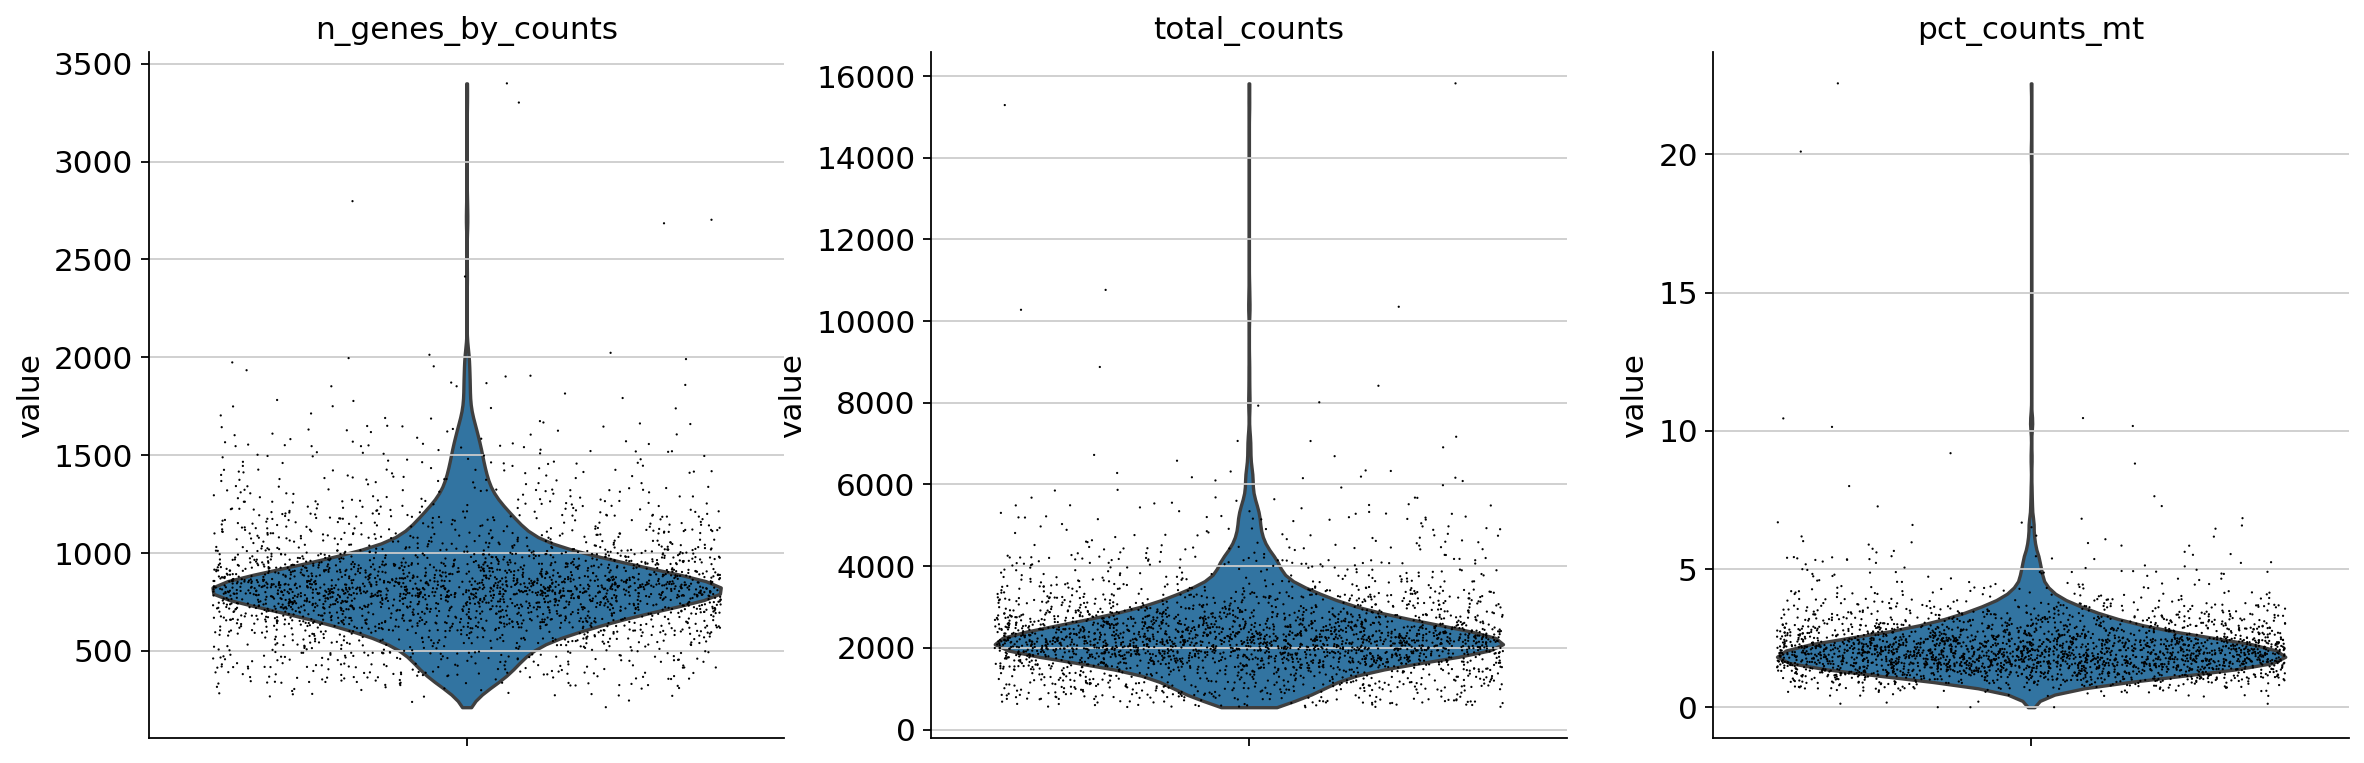

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

去除线粒体基因表达过多或总计数过多的细胞：

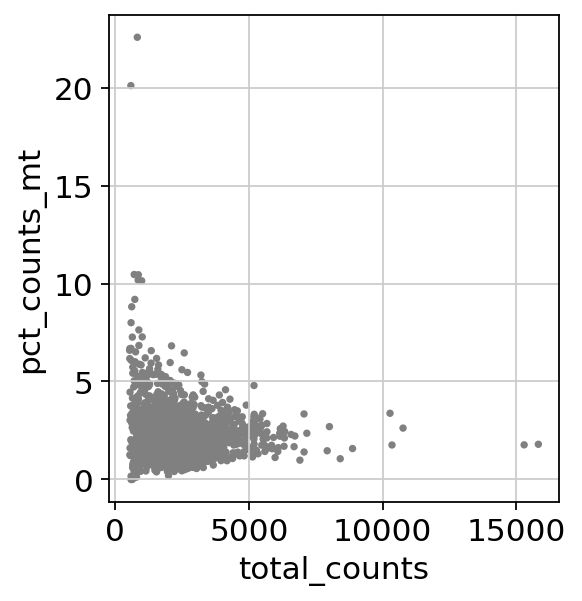

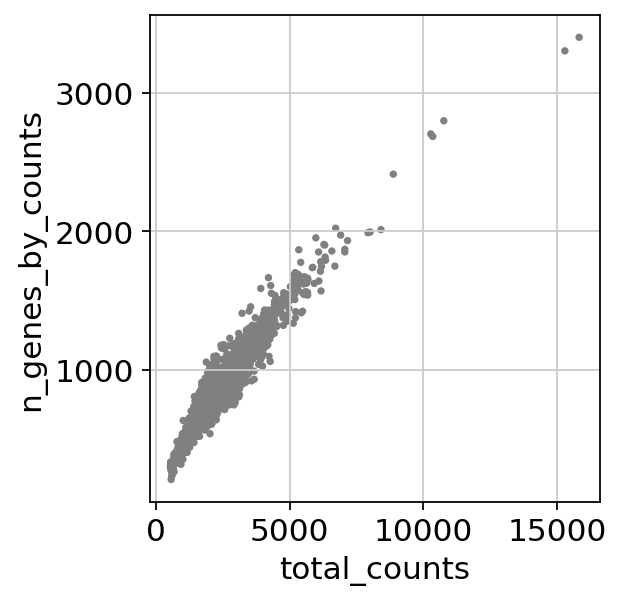

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

实际上，通过对 `AnData` 对象进行切片来进行过滤。

In [21]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

`normalize_total` 将数据矩阵 normalize 为每个细胞 10,000 个 reads，从而使 counts 在各个 细胞 之间具有可比性。

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/zhenghu/anaconda3/envs/scRNAseq/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


对数据进行对数运算：

In [23]:
sc.pp.log1p(adata)

识别高变基因

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


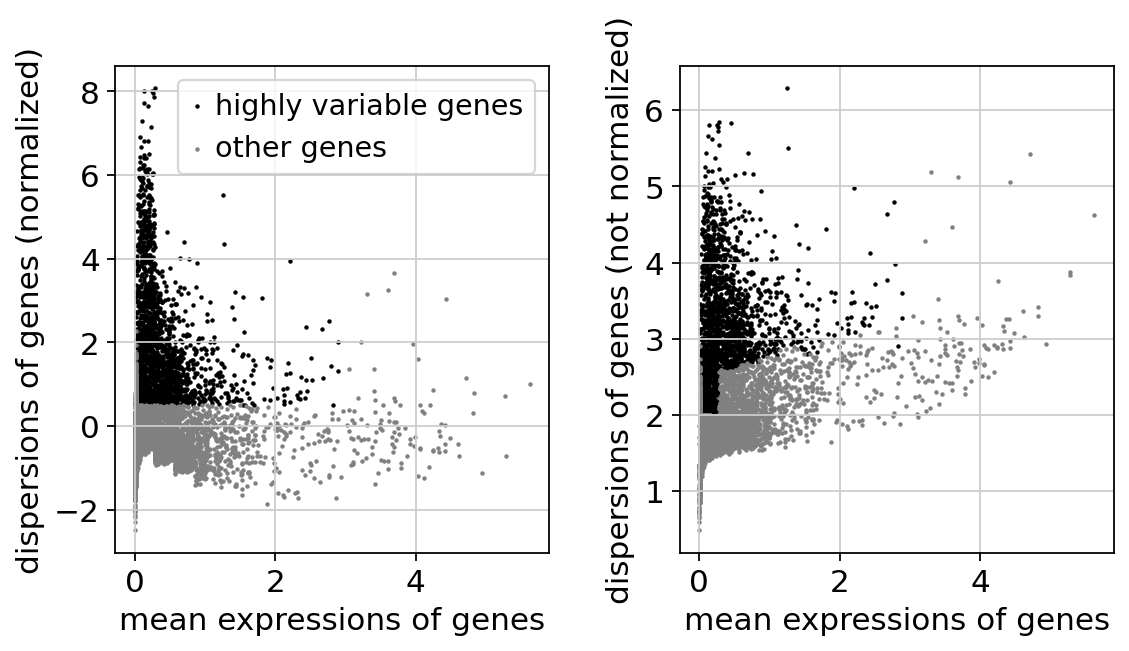

In [30]:
sc.pl.highly_variable_genes(adata)

将 AnData 对象的 `.raw` 属性设置为 normalized 和 logarithmized 的原始基因表达，以便稍后在基因表达的差异测试和可视化中使用。这只是冻结了 AnData 对象的状态。

您可以通过调用 `.raw.to_data()` 来获取 `.raw` 中对象的 `AnnData`。

In [31]:
adata.raw = adata

如果您不在下面使用 `sc.pp.regression_out` 更正数据并通过 `sc.pp.scale` 进行缩放，那么您也可以完全不使用 `.raw`。

先前的高变基因检测的结果作为注释存储在 `.var.highly_variable` 中，并由 PCA 自动检测，从而由 `sc.pp.neighbors` 和随后的流形/图工具自动检测。在这种情况下，实际上进行以下过滤的步骤也是不必要的。

实际进行过滤

In [35]:
adata = adata[:, adata.var.highly_variable]

对每个细胞的总计数和线粒体基因表达的百分比的影响进行回归。将数据缩放为单位方差。

In [37]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


将每个基因按单位方差进行缩放。剪裁值超过标准偏差 10。

In [38]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis
## 主成分分析

通过运行主成分分析（PCA）来降低数据的维度，主成分分析揭示了变化的主轴并对数据进行去噪。

In [39]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


我们可以在 PCA 坐标中绘制散点图，但以后不会使用。

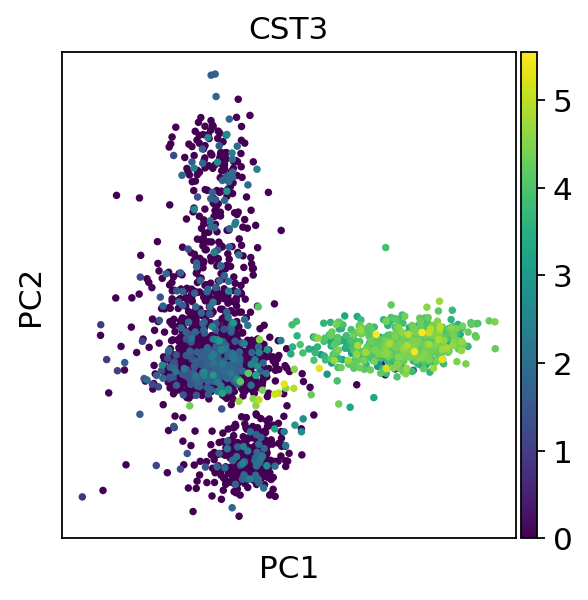

In [40]:
sc.pl.pca(adata, color='CST3')

让我们检查单个 PC 对数据总方差的贡献。这为我们提供了关于我们应该考虑多少 PC 来计算细胞的邻域关系的信息，例如在聚类函数 `sc.tl.louvain()` 或 tSNE `sc.tl.tSNE()` 中使用。根据我们的经验，通常粗略估计 PCs 的数量是可以的。

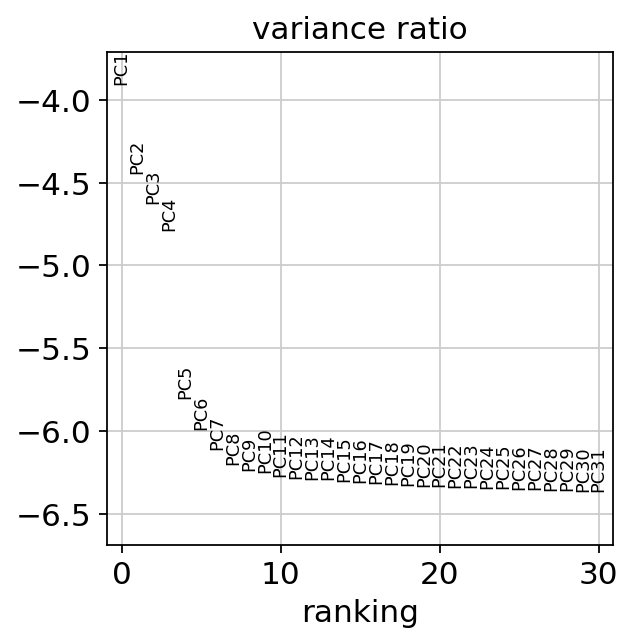

In [41]:
sc.pl.pca_variance_ratio(adata, log=True)

保存结果

In [42]:
adata.write(results_file)

In [43]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph
## 计算邻域图

让我们使用数据矩阵的 PCA 表示来计算细胞的邻域图。您可以在这里简单地使用默认值。为了重现 Seurat 的结果，让我们取以下值。

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph
## 嵌入邻域图

我们建议使用 UMAP 将图嵌入二维 ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)) ，见下文。它可能比 tSNE 更忠实于流形的全局连通性，也就是说，它更好地保留了轨迹。在某些场合中，您可能仍然会观察到断开连接的 clusters 和类似的连接冲突。它们通常可以通过运行来补救：

In [ ]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')

In [46]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


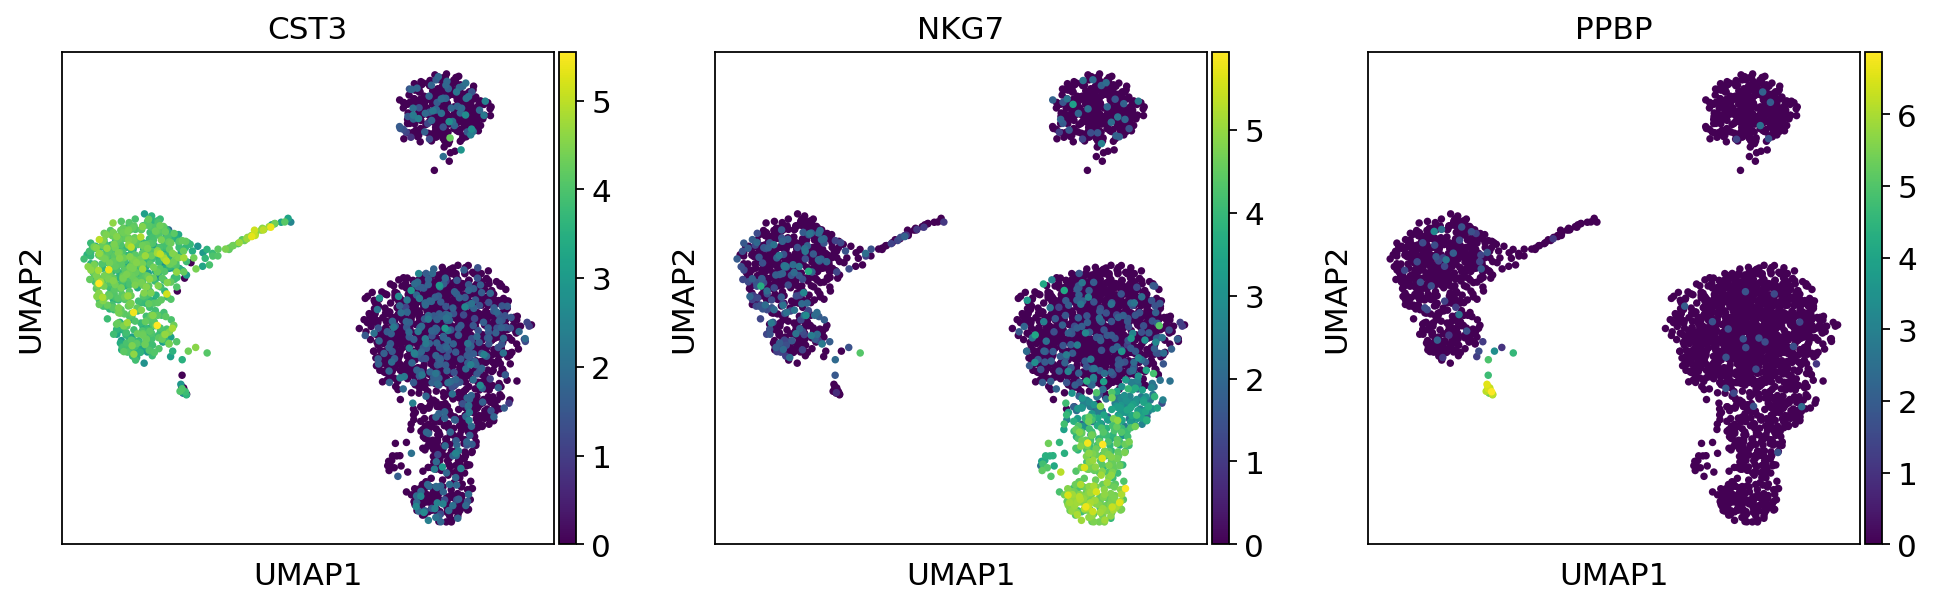

In [47]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

当我们设置 `adata` 的 `.raw` 属性时，前面的图显示了“raw”（normalized, logarithmized, but uncorrected）基因表达。你也可以通过明确声明你不想使用 `.raw` 来绘制 scaled 和 corrected 的基因表达。

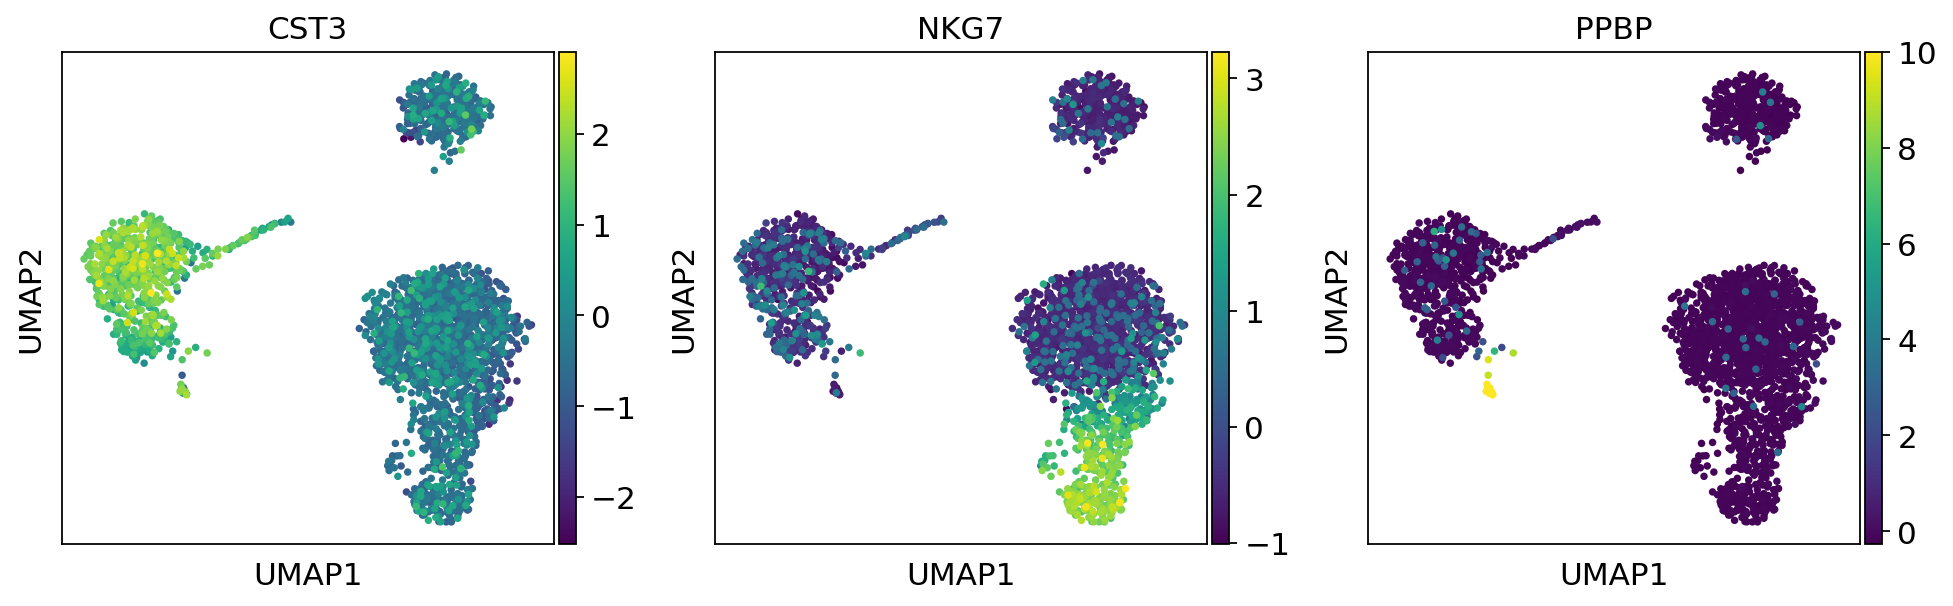

In [48]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph
## 对邻域图进行聚类

与 Seurat 和许多其他框架一样，我们推荐 [Traag et al. (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18) 的 Leiden 图聚类方法（基于优化模块性的社区检测）。注意，Leiden 聚类直接对细胞的邻域图进行聚类，我们在上一节中已经计算过了。

In [49]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


绘制聚类图，这与 Seurat 的结果非常一致。

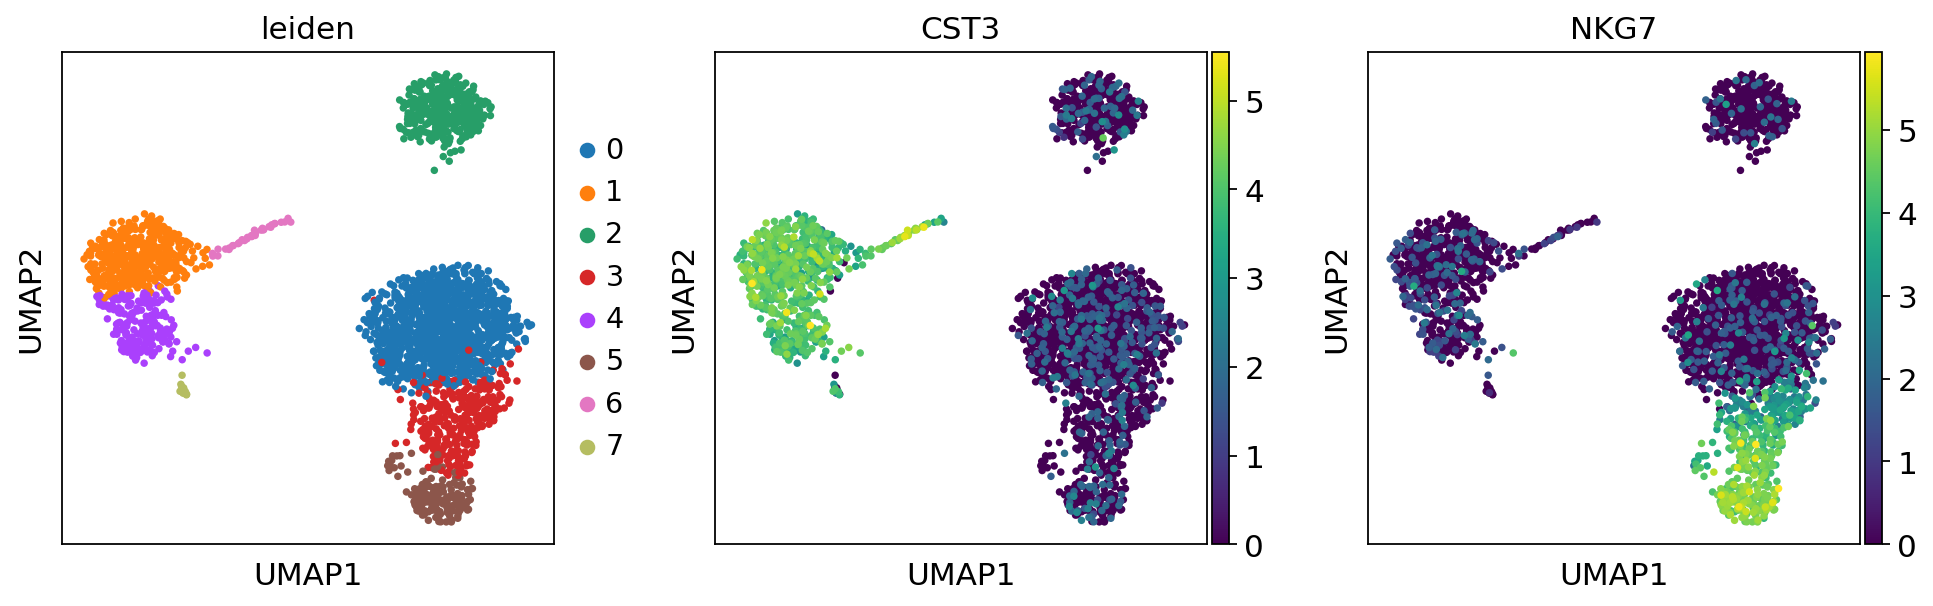

In [50]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

保存结果

In [51]:
adata.write(results_file)

## Finding marker genes
## 寻找标记基因

让我们计算每个聚类中高度差异基因的排名。为此，默认情况下，将使用 AnnData 的 `.raw` 属性，以防之前对其进行过初始化。最简单、最快的方法是 t-test。

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


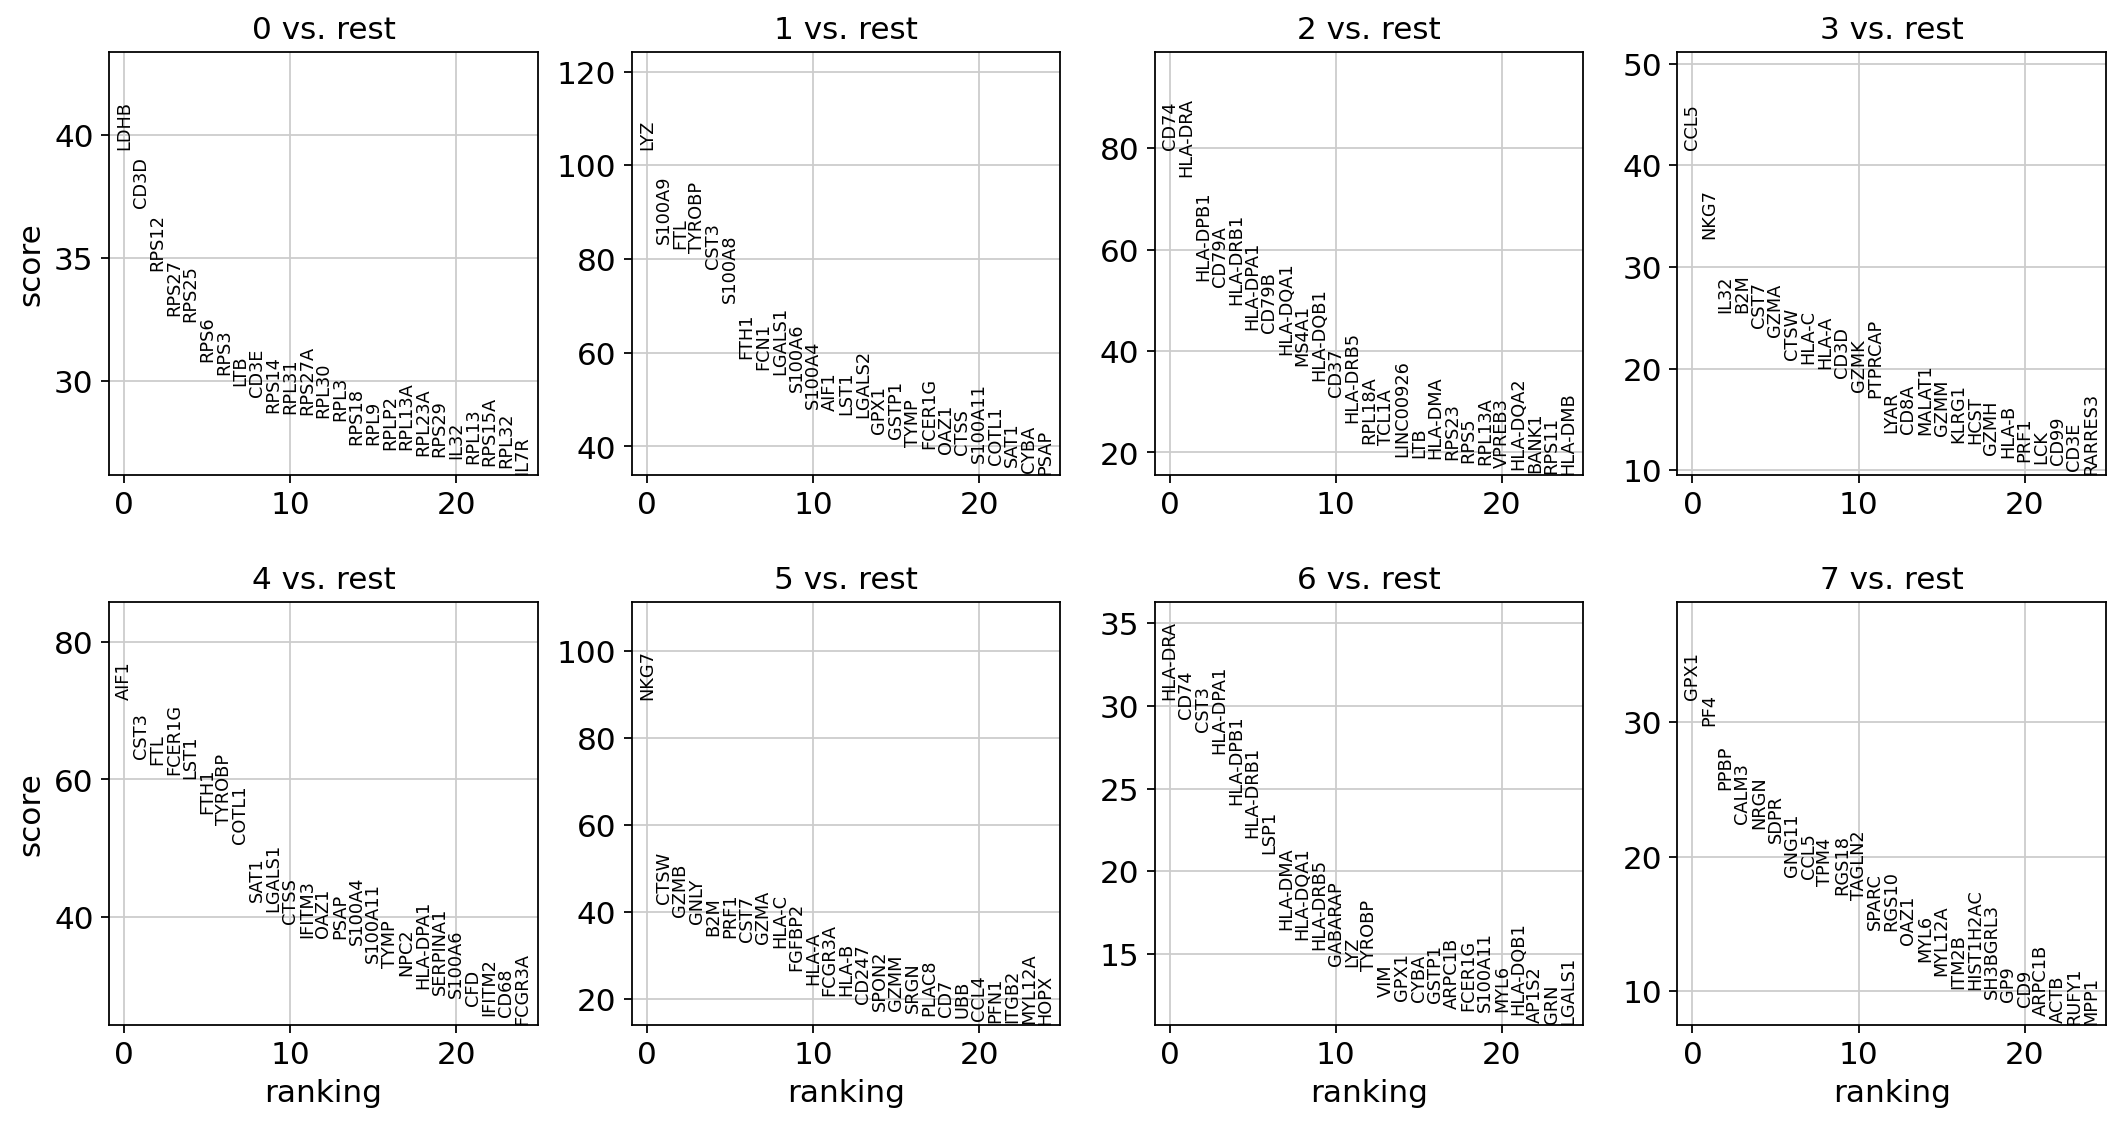

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [54]:
sc.settings.verbosity = 2  # reduce the verbosity

[Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) 检验的结果非常相似。我们建议在出版物中使用后者，例如参见 [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612)。您还可以考虑更强大的差异测试包，如 MAST、limma、DESeq2，对于python，还有最近的 diffxpy。

ranking genes
    finished (0:00:01)


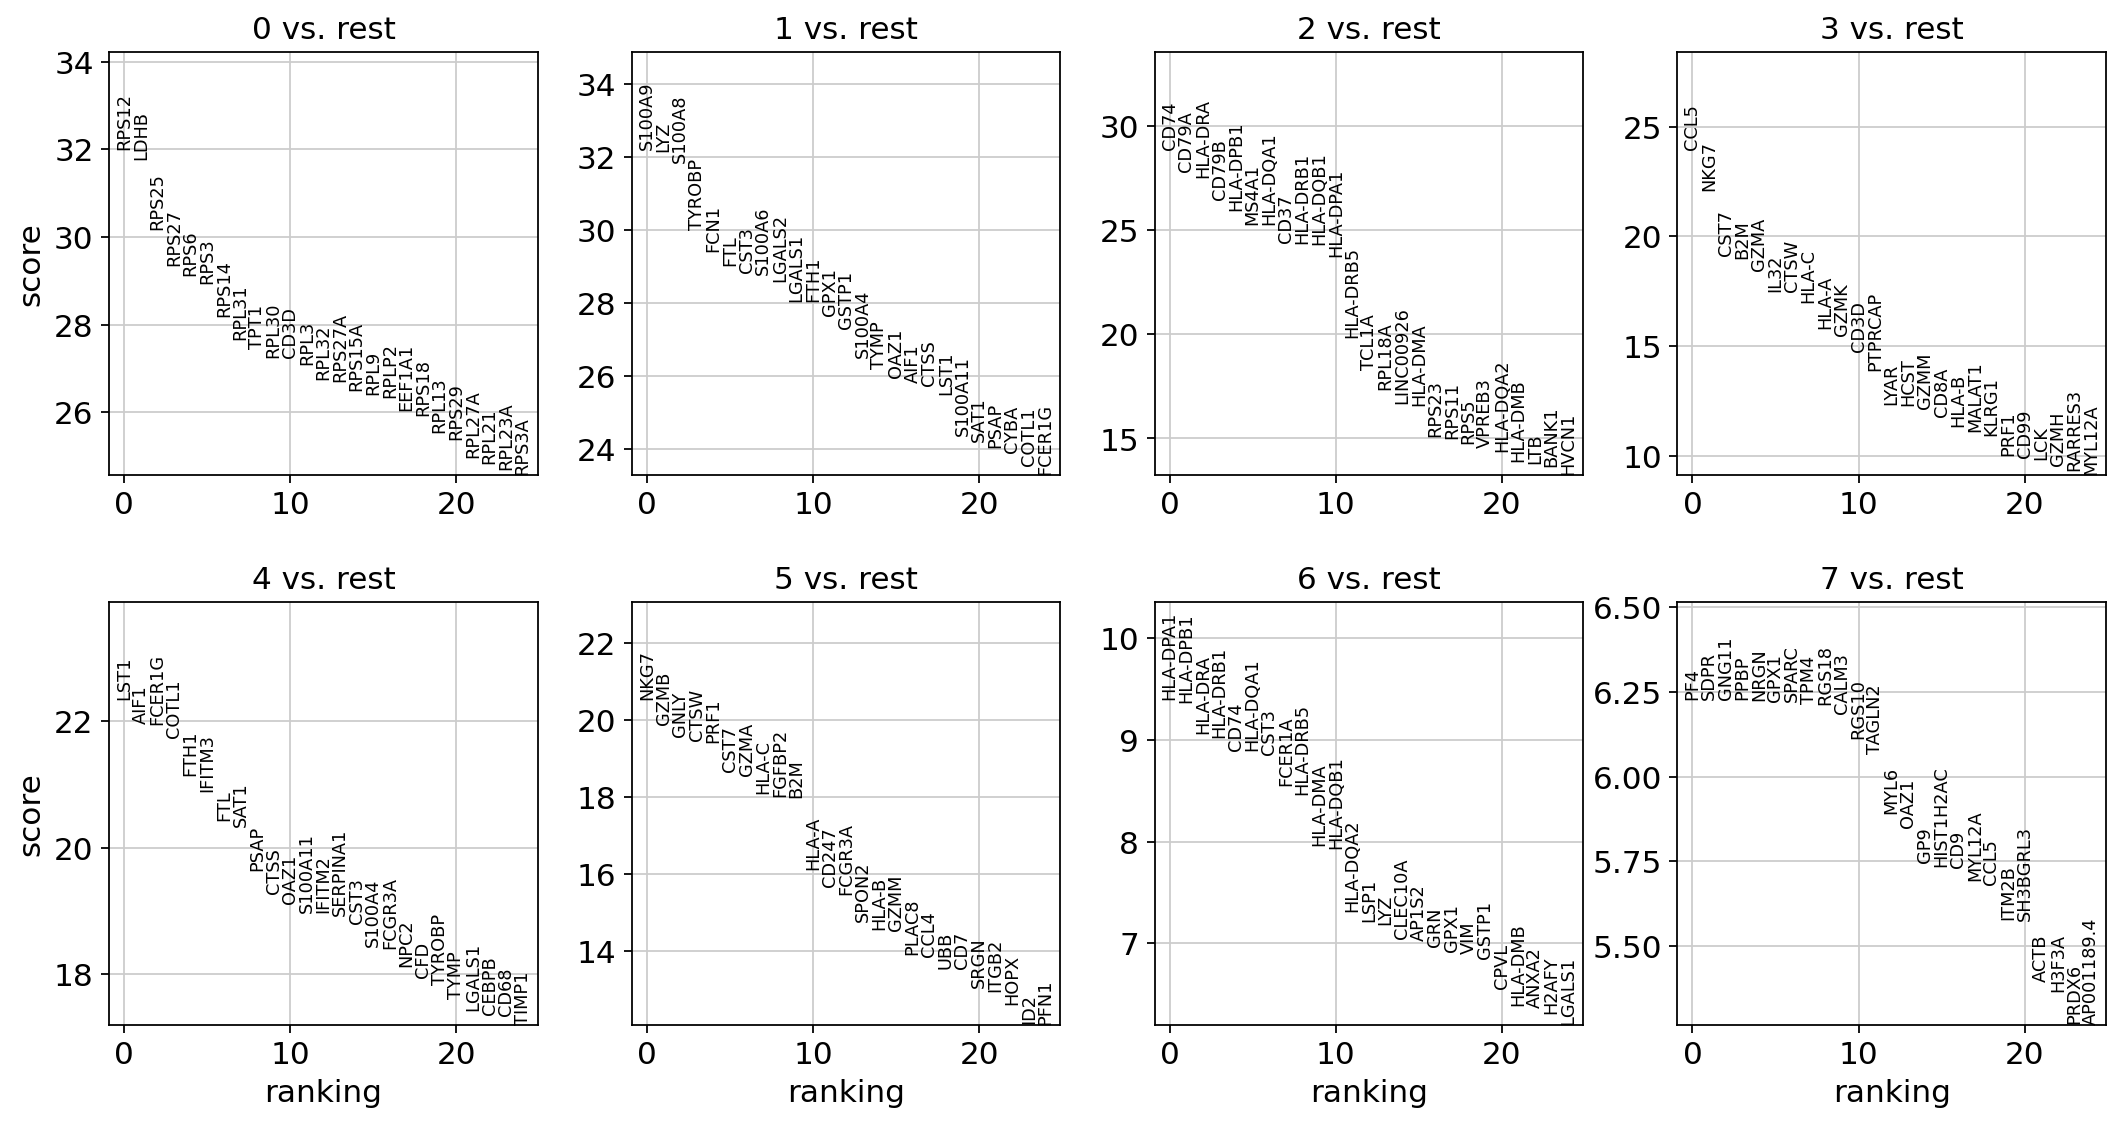

In [55]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

保存结果

In [56]:
adata.write(results_file)

作为一种选择，让我们使用逻辑回归对基因进行排序。例如，[Natranos et al. (2018)](https://doi.org/10.1101/258566) 提出了这一点。本质区别在于，在这里，我们使用多变量近似，而传统的微分测试是单变量的。[Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) 提供了更多细节。

ranking genes
    finished (0:00:03)


/home/zhenghu/anaconda3/envs/scRNAseq/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


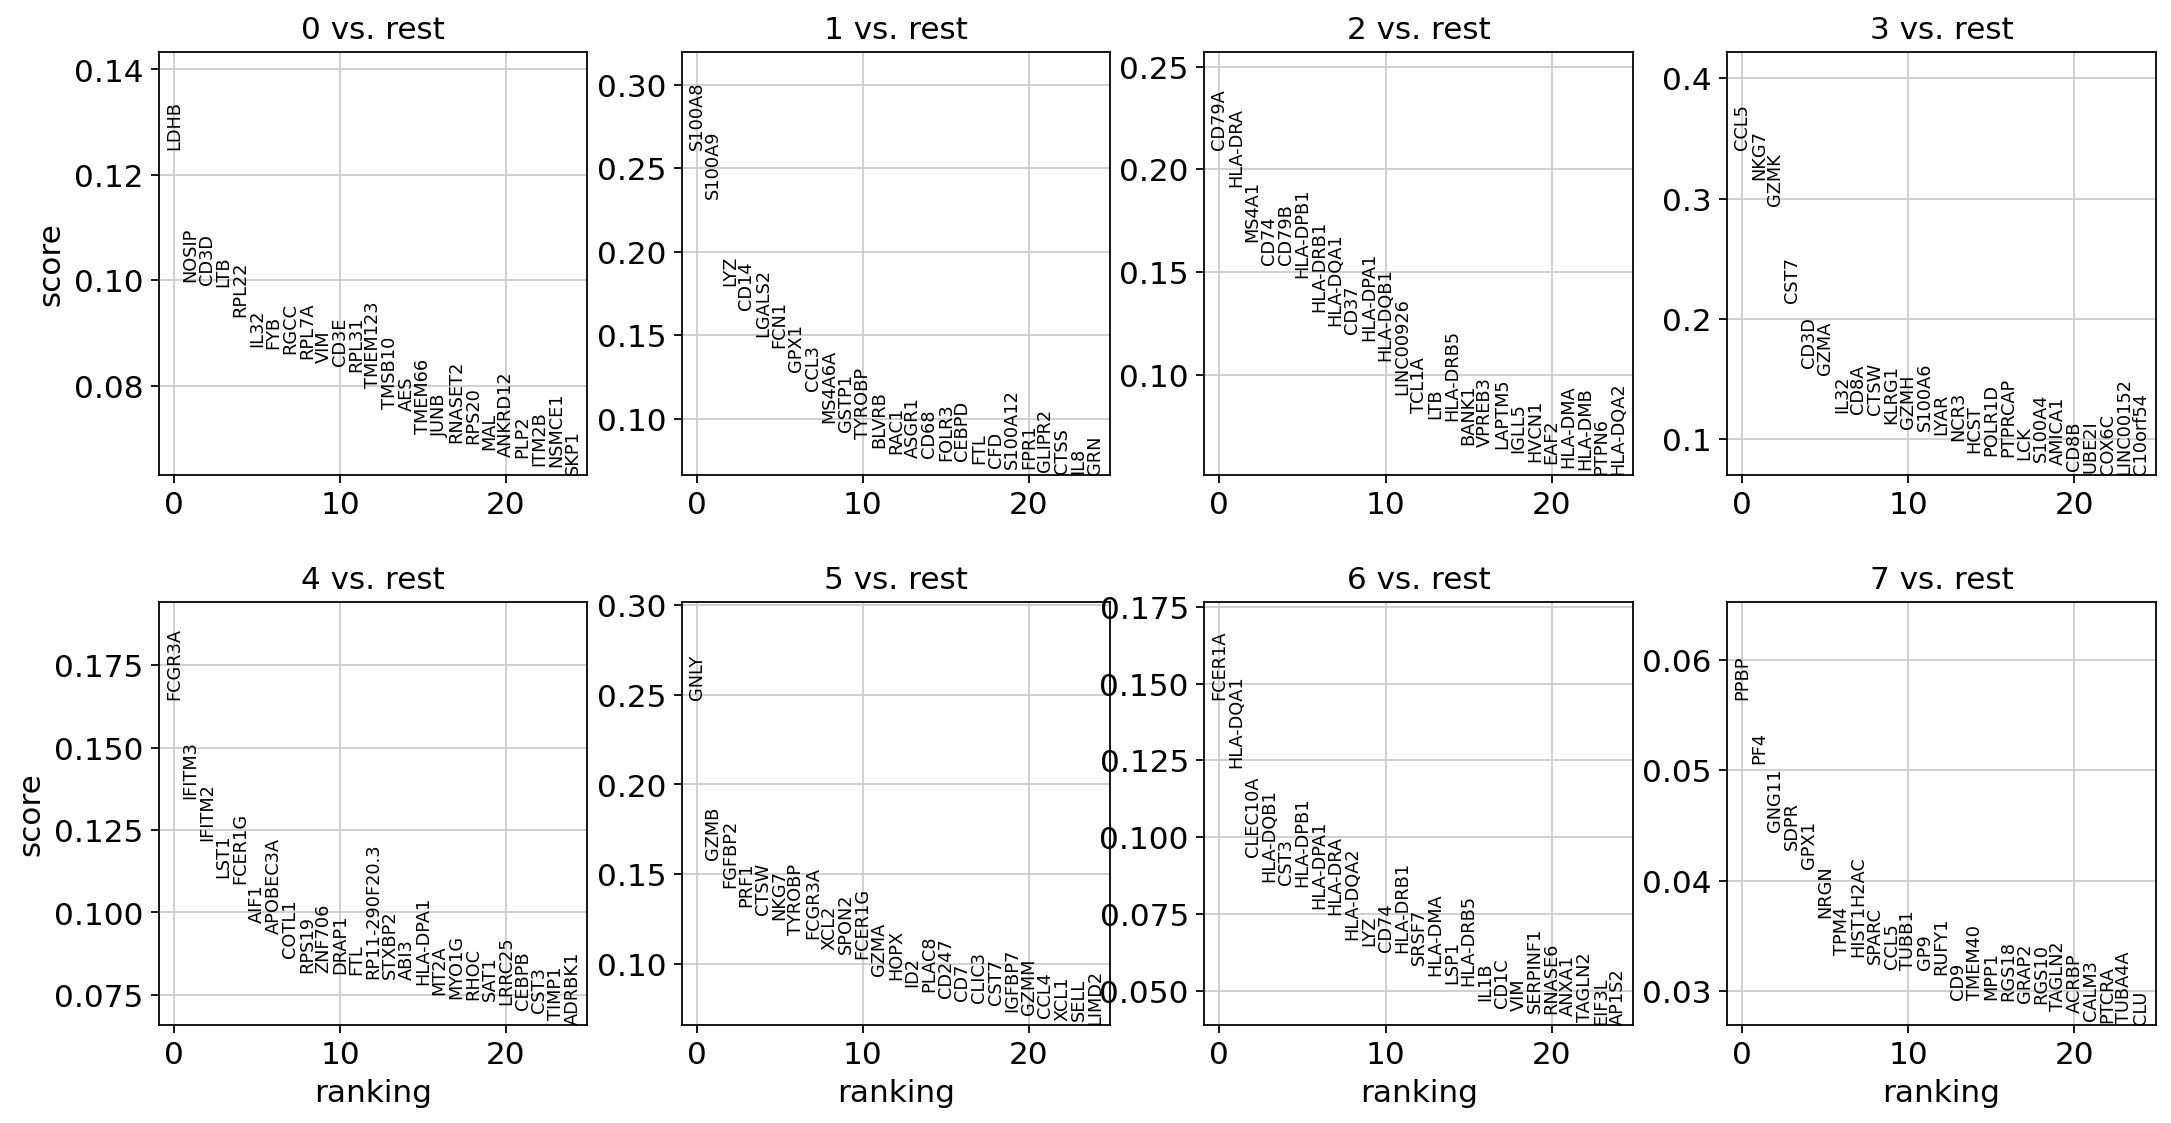

In [57]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

除了 IL7R（仅通过 t 检验发现）和 FCER1A（仅通过其他两种方法发现）之外，所有标记基因在所有方法中都被重复发现。

| Louvain Group | Markers | Cell Type |
|:---:|:---:|:---:|
|0|IL7R|CD4 T cells|
|1|CD14, LYZ|CD14+ Monocytes|
|2|MS4A1|B cells|
|3|CD8A|CD8 T cells|
|4|GNLY, NKG7|NK cells|
|5|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|6|FCER1A, CST3|Dendritic Cells|
|7|PPBP|Megakaryocytes|

让我们也定义一个标记基因的列表，以供以后参考。

In [58]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

使用 Wilcoxon Rank-Sum test 结果重新加载已保存的对象。

In [67]:
adata = sc.read(results_file)

在 dataframe 中显示每个 cluster 0、1、…、7 的 10 个排名靠前的基因。

In [68]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,AIF1,GZMB,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,CST7,FCER1G,GNLY,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,B2M,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN


找一张有分数和分组的表格。

In [69]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.238286e-224,S100A9,1.842655e-227,CD74,2.487145e-183,CCL5,6.969692e-127,LST1,1.419732e-110,NKG7,1.006113e-93,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,2.520407e-221,LYZ,8.413552e-227,CD79A,1.679730e-170,NKG7,3.765805e-108,AIF1,7.130846e-107,GZMB,5.598162e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,7.723960e-200,S100A8,1.257243e-222,HLA-DRA,6.942399e-167,CST7,1.187280e-81,FCER1G,1.045064e-106,GNLY,2.214727e-85,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,3.232559e-189,TYROBP,6.067012e-198,CD79B,2.569135e-154,B2M,2.397755e-80,COTL1,9.908055e-105,CTSW,2.404718e-84,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,2.474817e-186,FCN1,4.894805e-190,HLA-DPB1,3.580735e-148,GZMA,5.599438e-76,FTH1,3.935567e-99,PRF1,5.451777e-84,CD74,5.853161e-19,NRGN,4.800511e-10


与单个 cluster 进行比较：

In [70]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes


KeyError: 'base'

如果我们想要一个特定组的更详细的视图，请使用 `sc.pl.rank_genes_groups_violin`。

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

使用计算的微分表达式（即通过与其他组的比较来重新加载 DE）重新加载对象：

In [71]:
adata = sc.read(results_file)

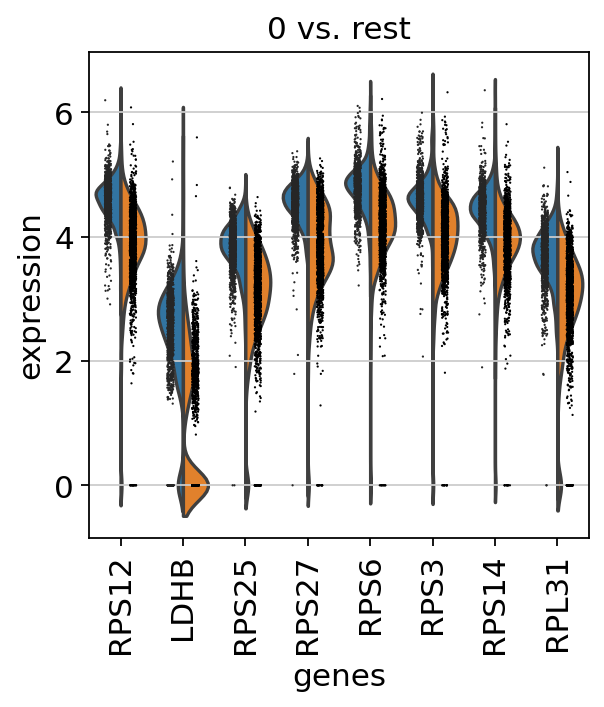

In [72]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

如果你想跨组比较某个基因，请使用以下方法。

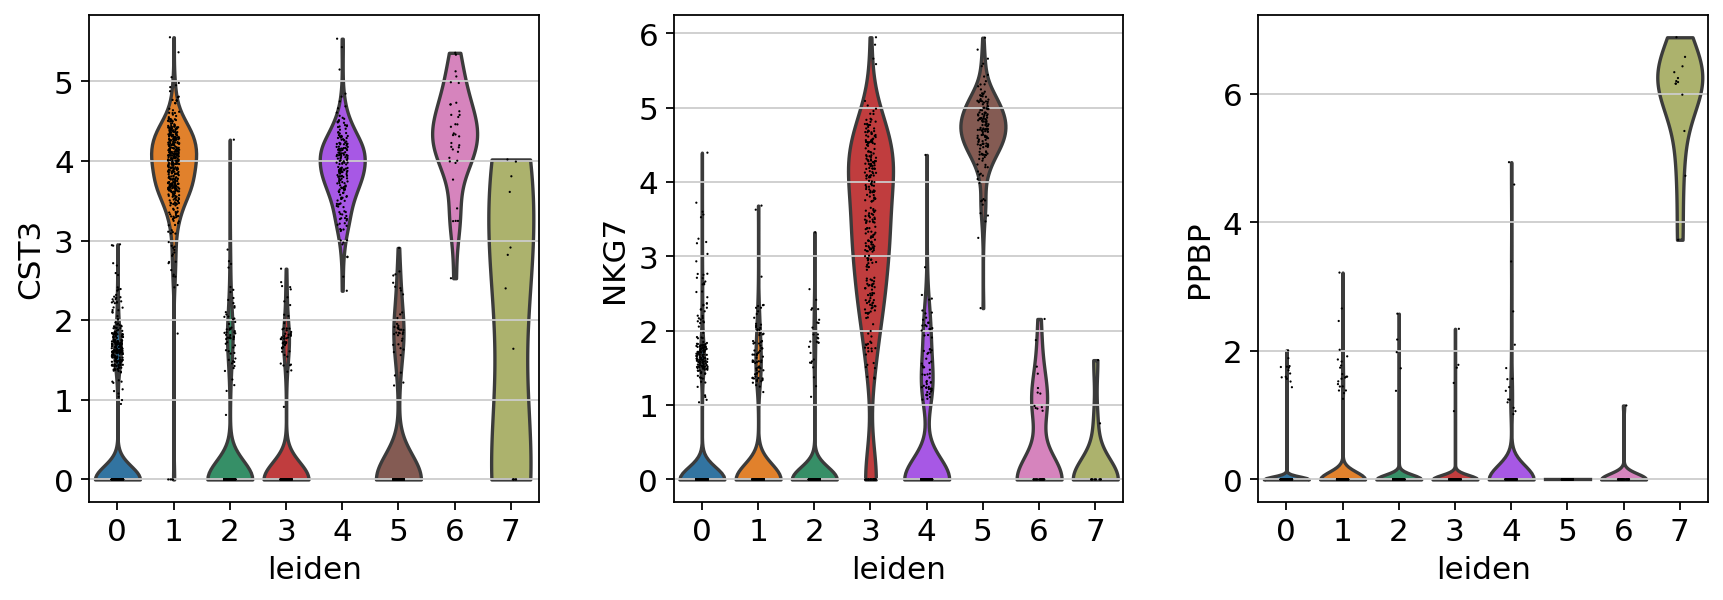

In [73]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

实际标记细胞类型。

In [74]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/home/zhenghu/.local/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


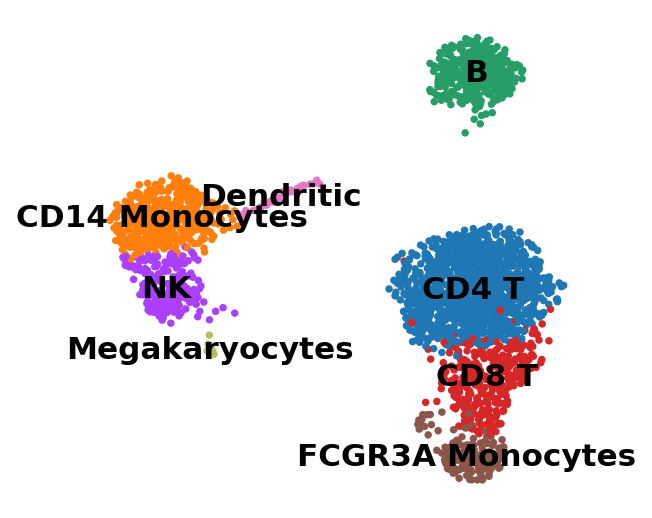

In [75]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

现在我们注释了细胞类型，让我们可视化标记基因。

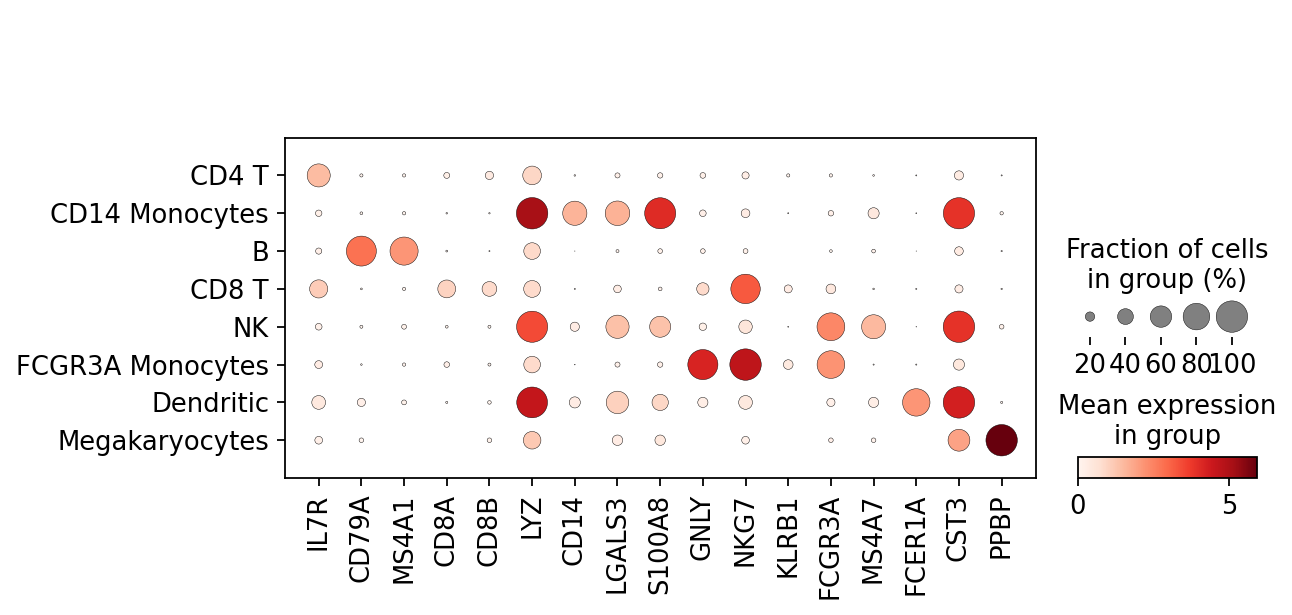

In [76]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

还有一个非常紧凑的小提琴图。

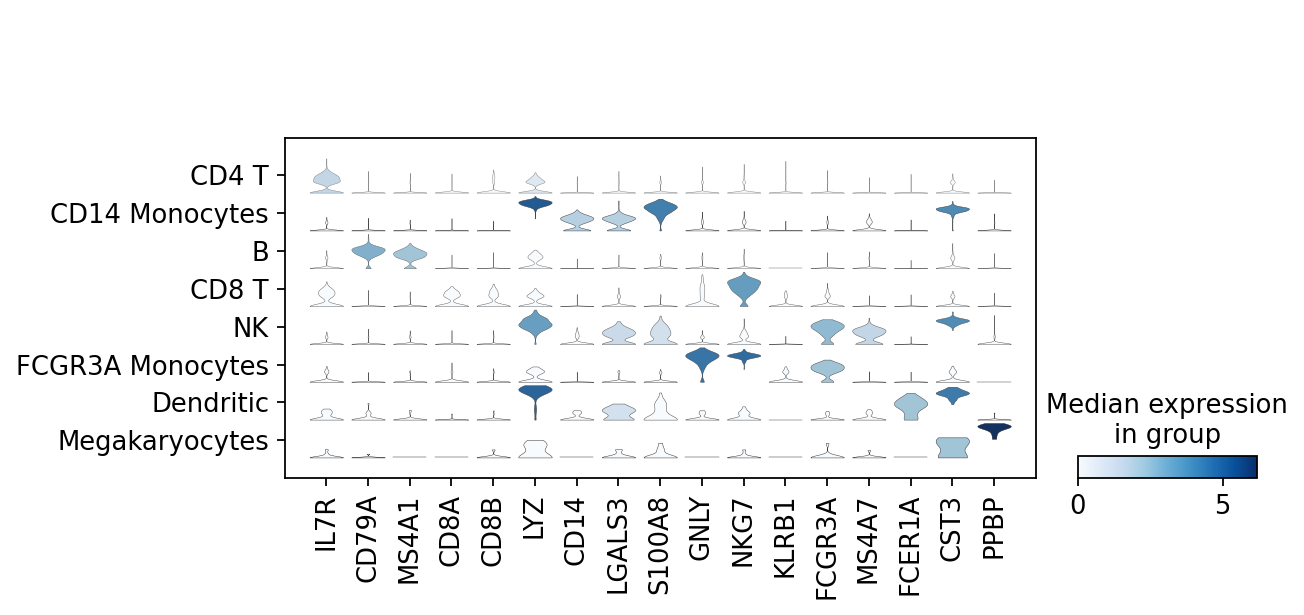

In [77]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

在分析过程中，AnData 积累了以下注释。

In [78]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [79]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

使用 `h5ls` 大致了解该文件，它有许多选项-有关更多详细信息，请参阅[此处](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md)。文件格式可能仍有待于未来的进一步优化。不过，所有读取功能都将保持向后兼容。

如果你想与那些只想将此文件用于可视化的人共享此文件，减少文件大小的一个简单方法是删除密集 scaled 和 corrected 的数据矩阵。该文件仍然包含 `adata.raw` 中可视化中使用的原始数据。

In [80]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

如果您想导出到“csv”，您有以下选项：

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )